<a href="https://colab.research.google.com/github/monicaneli/Deteccao-em-imagens-rede-Yolo/blob/main/Deteccao_em_imagens_rede_Yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção em imagens com a rede YOLO

O projeto teve como objetivo a detecção de objetos em imagens utilizando a rede YOLO (*You Only Look Once*), uma das arquiteturas mais eficientes para tarefas de visão computacional em tempo real. O foco principal foi aplicar o treinamento da rede YOLO sobre imagens já rotuladas, de forma a gerar um modelo capaz de identificar e localizar múltiplas classes de objetos em imagens novas.

Para fins de prototipagem e considerando as limitações de memória e processamento do Google Colab, foi utilizado apenas o conjunto de validação do COCO 2017 (val2017.zip), contendo aproximadamente 5.000 imagens. Apesar de não abranger todo o dataset, esse subset permitiu demonstrar a viabilidade do treinamento, geração de arquivos de labels no formato YOLO, e avaliação do modelo utilizando métricas padrão como precision, recall e mAP.

O workflow do projeto incluiu:

- Preparação do dataset: download das imagens e anotações, conversão das labels do formato COCO para YOLO, e criação de um split de treino, validação e teste.

- Treinamento do modelo YOLO: configuração de hiperparâmetros (tamanho da imagem, batch size, número de épocas) e salvamento dos pesos (best.pt e last.pt).

- Validação e avaliação: cálculo de métricas de desempenho e visualização de bounding boxes em imagens de teste.

## Resultados
Este projeto demonstra a capacidade do YOLO de detectar múltiplas classes de objetos em imagens complexas, mesmo utilizando apenas um subconjunto reduzido do dataset. Ele serve como base para expansões futuras, incluindo o uso de datasets completos, otimização de hiperparâmetros e integração com aplicações em tempo real.

In [16]:
# Imports, parâmetros e funções
import os
import shutil
import json
from PIL import Image as PILImage, ImageDraw, ImageFont  # Corrected import name
from IPython.display import display, Image # Keep display and Image from IPython.display
import glob
from collections import defaultdict
import random
import numpy as np
import yaml

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

def convert_coco_to_yolo(annotation, img_width, img_height):
    x, y, w, h = annotation['bbox']
    x_center = (x + w/2) / img_width
    y_center = (y + h/2) / img_height
    w_norm = w / img_width
    h_norm = h / img_height
    class_id = annotation['category_id'] - 1  # YOLO classes começam em 0
    return class_id, x_center, y_center, w_norm, h_norm


def dataset_summary(split_dir, batch_size=16):
    images = glob.glob(os.path.join(split_dir, "images", "*.jpg"))
    labels = glob.glob(os.path.join(split_dir, "labels", "*.txt"))
    print(f"Split: {os.path.basename(split_dir)}")
    print(f"  Images: {len(images)}")
    print(f"  Labels: {len(labels)}")
    print(f"  Batches (batch_size={batch_size}): {len(images)//batch_size}")

    # Contar classes
    class_counts = defaultdict(int)
    for lbl_file in labels:
        with open(lbl_file) as f:
            for line in f:
                class_id = int(line.split()[0])
                class_counts[class_id] += 1
    print(f"  Classes distribution: {dict(class_counts)}")
    print(f"  Número de Classes: {len(class_counts)}\n")

def convert_coco_to_yolo(annotation, img_width, img_height):
    x, y, w, h = annotation['bbox']
    x_center = (x + w/2) / img_width
    y_center = (y + h/2) / img_height
    w_norm = w / img_width
    h_norm = h / img_height
    coco_id = annotation['category_id']
    class_id = coco_id_to_yolo[coco_id]  # mapeamento para 0..79
    return class_id, x_center, y_center, w_norm, h_norm

## Base de dados COCO VAL2017

In [2]:
# Baixando a base de dados com imagens já rotuladas do COCO, apenas o conjunto de validação (val2017.zip ~1 GB e 5 k imagens)
# Criar diretório
!mkdir -p /content/coco/images
!mkdir -p /content/coco/annotations

# Baixar apenas validação
!curl -L -o /content/coco/images/val2017.zip http://images.cocodataset.org/zips/val2017.zip
!curl -L -o /content/coco/annotations/annotations_trainval2017.zip http://images.cocodataset.org/annotations/annotations_trainval2017.zip

# Descompactar
!unzip -q /content/coco/images/val2017.zip -d /content/coco/images/
!unzip -q /content/coco/annotations/annotations_trainval2017.zip -d /content/coco/


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  777M  100  777M    0     0  16.6M      0  0:00:46  0:00:46 --:--:-- 17.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  241M  100  241M    0     0  15.5M      0  0:00:15  0:00:15 --:--:-- 17.9M


### Preparando a base de dados

In [3]:
# Preparando a base de dados
BASE_DIR = "/content/coco"
IMAGES_DIR = os.path.join(BASE_DIR, "images", "val2017")
ANNOTATIONS_FILE = os.path.join(BASE_DIR, "annotations", "instances_val2017.json")

TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "val")
TEST_DIR = os.path.join(BASE_DIR, "test")

# Criar pastas train/val/test
for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(os.path.join(d, "images"), exist_ok=True)
    os.makedirs(os.path.join(d, "labels"), exist_ok=True)

# Ler COCO JSON
with open(ANNOTATIONS_FILE, "r") as f:
    coco = json.load(f)

# Criar mapeamento COCO category_id -> 0..79
categories = sorted(coco['categories'], key=lambda c: c['id'])
coco_id_to_yolo = {cat['id']: i for i, cat in enumerate(categories)}
print("Exemplo de mapeamento:", list(coco_id_to_yolo.items())[:5])

# Agrupar annotations por image_id
image_annotations = defaultdict(list)
for ann in coco['annotations']:
    image_annotations[ann['image_id']].append(ann)

# Lista de imagens
images_info = {img['id']: img['file_name'] for img in coco['images']}
all_images = list(images_info.values())

# Shuffle e split 70/20/10
import random
random.seed(42)
random.shuffle(all_images)
n = len(all_images)
splits = {
    TRAIN_DIR: all_images[:int(0.7*n)],
    VAL_DIR: all_images[int(0.7*n):int(0.9*n)],
    TEST_DIR: all_images[int(0.9*n):]
}

# Gerar arquivos .txt e copiar imagens
for split_dir, img_list in splits.items():
    for img_name in img_list:
        img_id = [k for k,v in images_info.items() if v == img_name][0]
        anns = image_annotations.get(img_id, [])

        # Copiar imagem
        src_img = os.path.join(IMAGES_DIR, img_name)
        dst_img = os.path.join(split_dir, "images", img_name)
        shutil.copyfile(src_img, dst_img)

        # Criar labels
        from PIL import Image # Import Image from PIL here
        with Image.open(dst_img) as im:
            width, height = im.size
        yolo_lines = []
        for ann in anns:
            class_id, xc, yc, w, h = convert_coco_to_yolo(ann, width, height)
            yolo_lines.append(f"{class_id} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}")
        if yolo_lines:
            label_path = os.path.join(split_dir, "labels", img_name.replace(".jpg", ".txt"))
            with open(label_path, "w") as f:
                f.write("\n".join(yolo_lines))

print("Arquivos .txt gerados com mapeamento correto 0..79. Pronto para YOLOv5.")

Exemplo de mapeamento: [(1, 0), (2, 1), (3, 2), (4, 3), (5, 4)]
Arquivos .txt gerados com mapeamento correto 0..79. Pronto para YOLOv5.


In [4]:
#Summary do dataset

# Pega apenas os nomes
class_names = [cat["name"] for cat in categories]
category_dict = {cat["id"]: cat["name"] for cat in categories}# Mapeia id -> nome

print(f"Classes: {list(category_dict.values())}")
for split_dir in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    dataset_summary(split_dir)

Classes: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
Split: train
  Images: 3500
  Labels: 3474
  Batches (batch_size=16): 218
  Classes distribution: {14: 338, 15: 147, 16: 164, 29:

## Instalação, configuração e treinamento da Rede YOLOv5

In [5]:
#Criar o arquivo de configuração do dataset (YAML)
yaml_content = """# Dataset COCO (val2017)
train: /content/coco/train/images
val: /content/coco/val/images
test: /content/coco/test/images

nc: 80

names:
  - person
  - bicycle
  - car
  - motorcycle
  - airplane
  - bus
  - train
  - truck
  - boat
  - traffic light
  - fire hydrant
  - stop sign
  - parking meter
  - bench
  - bird
  - cat
  - dog
  - horse
  - sheep
  - cow
  - elephant
  - bear
  - zebra
  - giraffe
  - backpack
  - umbrella
  - handbag
  - tie
  - suitcase
  - frisbee
  - skis
  - snowboard
  - sports ball
  - kite
  - baseball bat
  - baseball glove
  - skateboard
  - surfboard
  - tennis racket
  - bottle
  - wine glass
  - cup
  - fork
  - knife
  - spoon
  - bowl
  - banana
  - apple
  - sandwich
  - orange
  - broccoli
  - carrot
  - hot dog
  - pizza
  - donut
  - cake
  - chair
  - couch
  - potted plant
  - bed
  - dining table
  - toilet
  - tv
  - laptop
  - mouse
  - remote
  - keyboard
  - cell phone
  - microwave
  - oven
  - toaster
  - sink
  - refrigerator
  - book
  - clock
  - vase
  - scissors
  - teddy bear
  - hair drier
  - toothbrush
"""

with open("/content/coco_val.yaml", "w") as f:
    f.write(yaml_content)

print("Arquivo coco_val.yaml criado com sucesso!")

Arquivo coco_val.yaml criado com sucesso!


In [6]:
#Instalar a implementação do YOLO
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17581, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 17581 (delta 42), reused 12 (delta 10), pack-reused 17508 (from 3)
Receiving objects: 100% (17581/17581), 16.64 MiB | 10.39 MiB/s, done.
Resolving deltas: 100% (12036/12036), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.8 MB/s eta 0:00:00


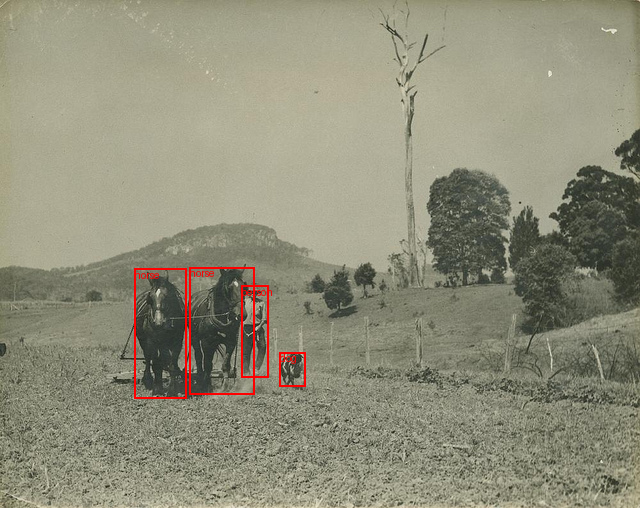

In [7]:
# Imagem de exemplo
IMAGES_DIR = "/content/coco/train/images"
LABELS_DIR = "/content/coco/train/labels"

# Carregar nomes das classes do YAML
with open("/content/coco_val.yaml") as f:
    data_yaml = yaml.safe_load(f)
names = data_yaml['names']  # lista de strings das classes

# Escolher uma imagem aleatória
img_name = random.choice(os.listdir(IMAGES_DIR))
img_path = os.path.join(IMAGES_DIR, img_name)

# Correspondente arquivo de label
label_name = img_name.replace(".jpg", ".txt")
label_path = os.path.join(LABELS_DIR, label_name)

# Abrir imagem
img = Image.open(img_path)
draw = ImageDraw.Draw(img)
width, height = img.size

# Opcional: usar fonte para o texto
try:
    font = ImageFont.truetype("arial.ttf", 16)
except:
    font = ImageFont.load_default()

# Ler labels YOLO e desenhar boxes com nomes
if os.path.exists(label_path):
    with open(label_path, "r") as f:
        for line in f.readlines():
            class_id, xc, yc, w, h = map(float, line.strip().split())
            x1 = (xc - w/2) * width
            y1 = (yc - h/2) * height
            x2 = (xc + w/2) * width
            y2 = (yc + h/2) * height
            draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
            draw.text((x1, y1), names[int(class_id)], fill="red", font=font)

# Exibir imagem
display(img)

In [8]:
!rm -rf /content/coco/train/labels.cache
%env WANDB_MODE=disabled
!python train.py --img 640 --batch 16 --epochs 50 --data /content/coco_val.yaml --weights yolov5s.pt --project runs/train --name exp1 --exist-ok

A saída de streaming foi truncada nas últimas 5000 linhas.
      38/49      5.82G    0.04266    0.05868    0.01311        275        640:  93% 203/219 [01:26<00:05,  2.68it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      38/49      5.82G    0.04264    0.05863    0.01311        178        640:  93% 204/219 [01:27<00:06,  2.48it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      38/49      5.82G    0.04267    0.05864     0.0131        243        640:  94% 205/219 [01:27<00:05,  2.78it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      38/49      5.82G 

### Validação do Modelo

In [9]:
#50 epochs completed in 1.499 hours.
#Optimizer stripped from runs/train/exp1/weights/last.pt, 14.8MB
#Optimizer stripped from runs/train/exp1/weights/best.pt, 14.8MB
#Validating runs/train/exp1/weights/best.pt...
#Results saved to runs/train/exp1

In [10]:
!python val.py --weights runs/train/exp1/weights/best.pt \
               --data /content/coco_val.yaml \
               --img 640 \
               --batch 16 \
               --task val --save-json

val: data=/content/coco_val.yaml, weights=['runs/train/exp1/weights/best.pt'], batch_size=16, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=True, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-430-g459d8bf0 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
val: Scanning /content/coco/val/labels.cache... 984 images, 16 backgrounds, 0 corrupt: 100% 1000/1000 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 63/63 [00:17<00:00,  3.60it/s]
                   all       1000       7031      0.615      0.517      0.549       0.35
Speed: 0.2ms pre-process, 5.3ms inference, 3.3ms NMS per image at shape (16, 3, 640, 640)

Evaluating pycocotools mAP... sa

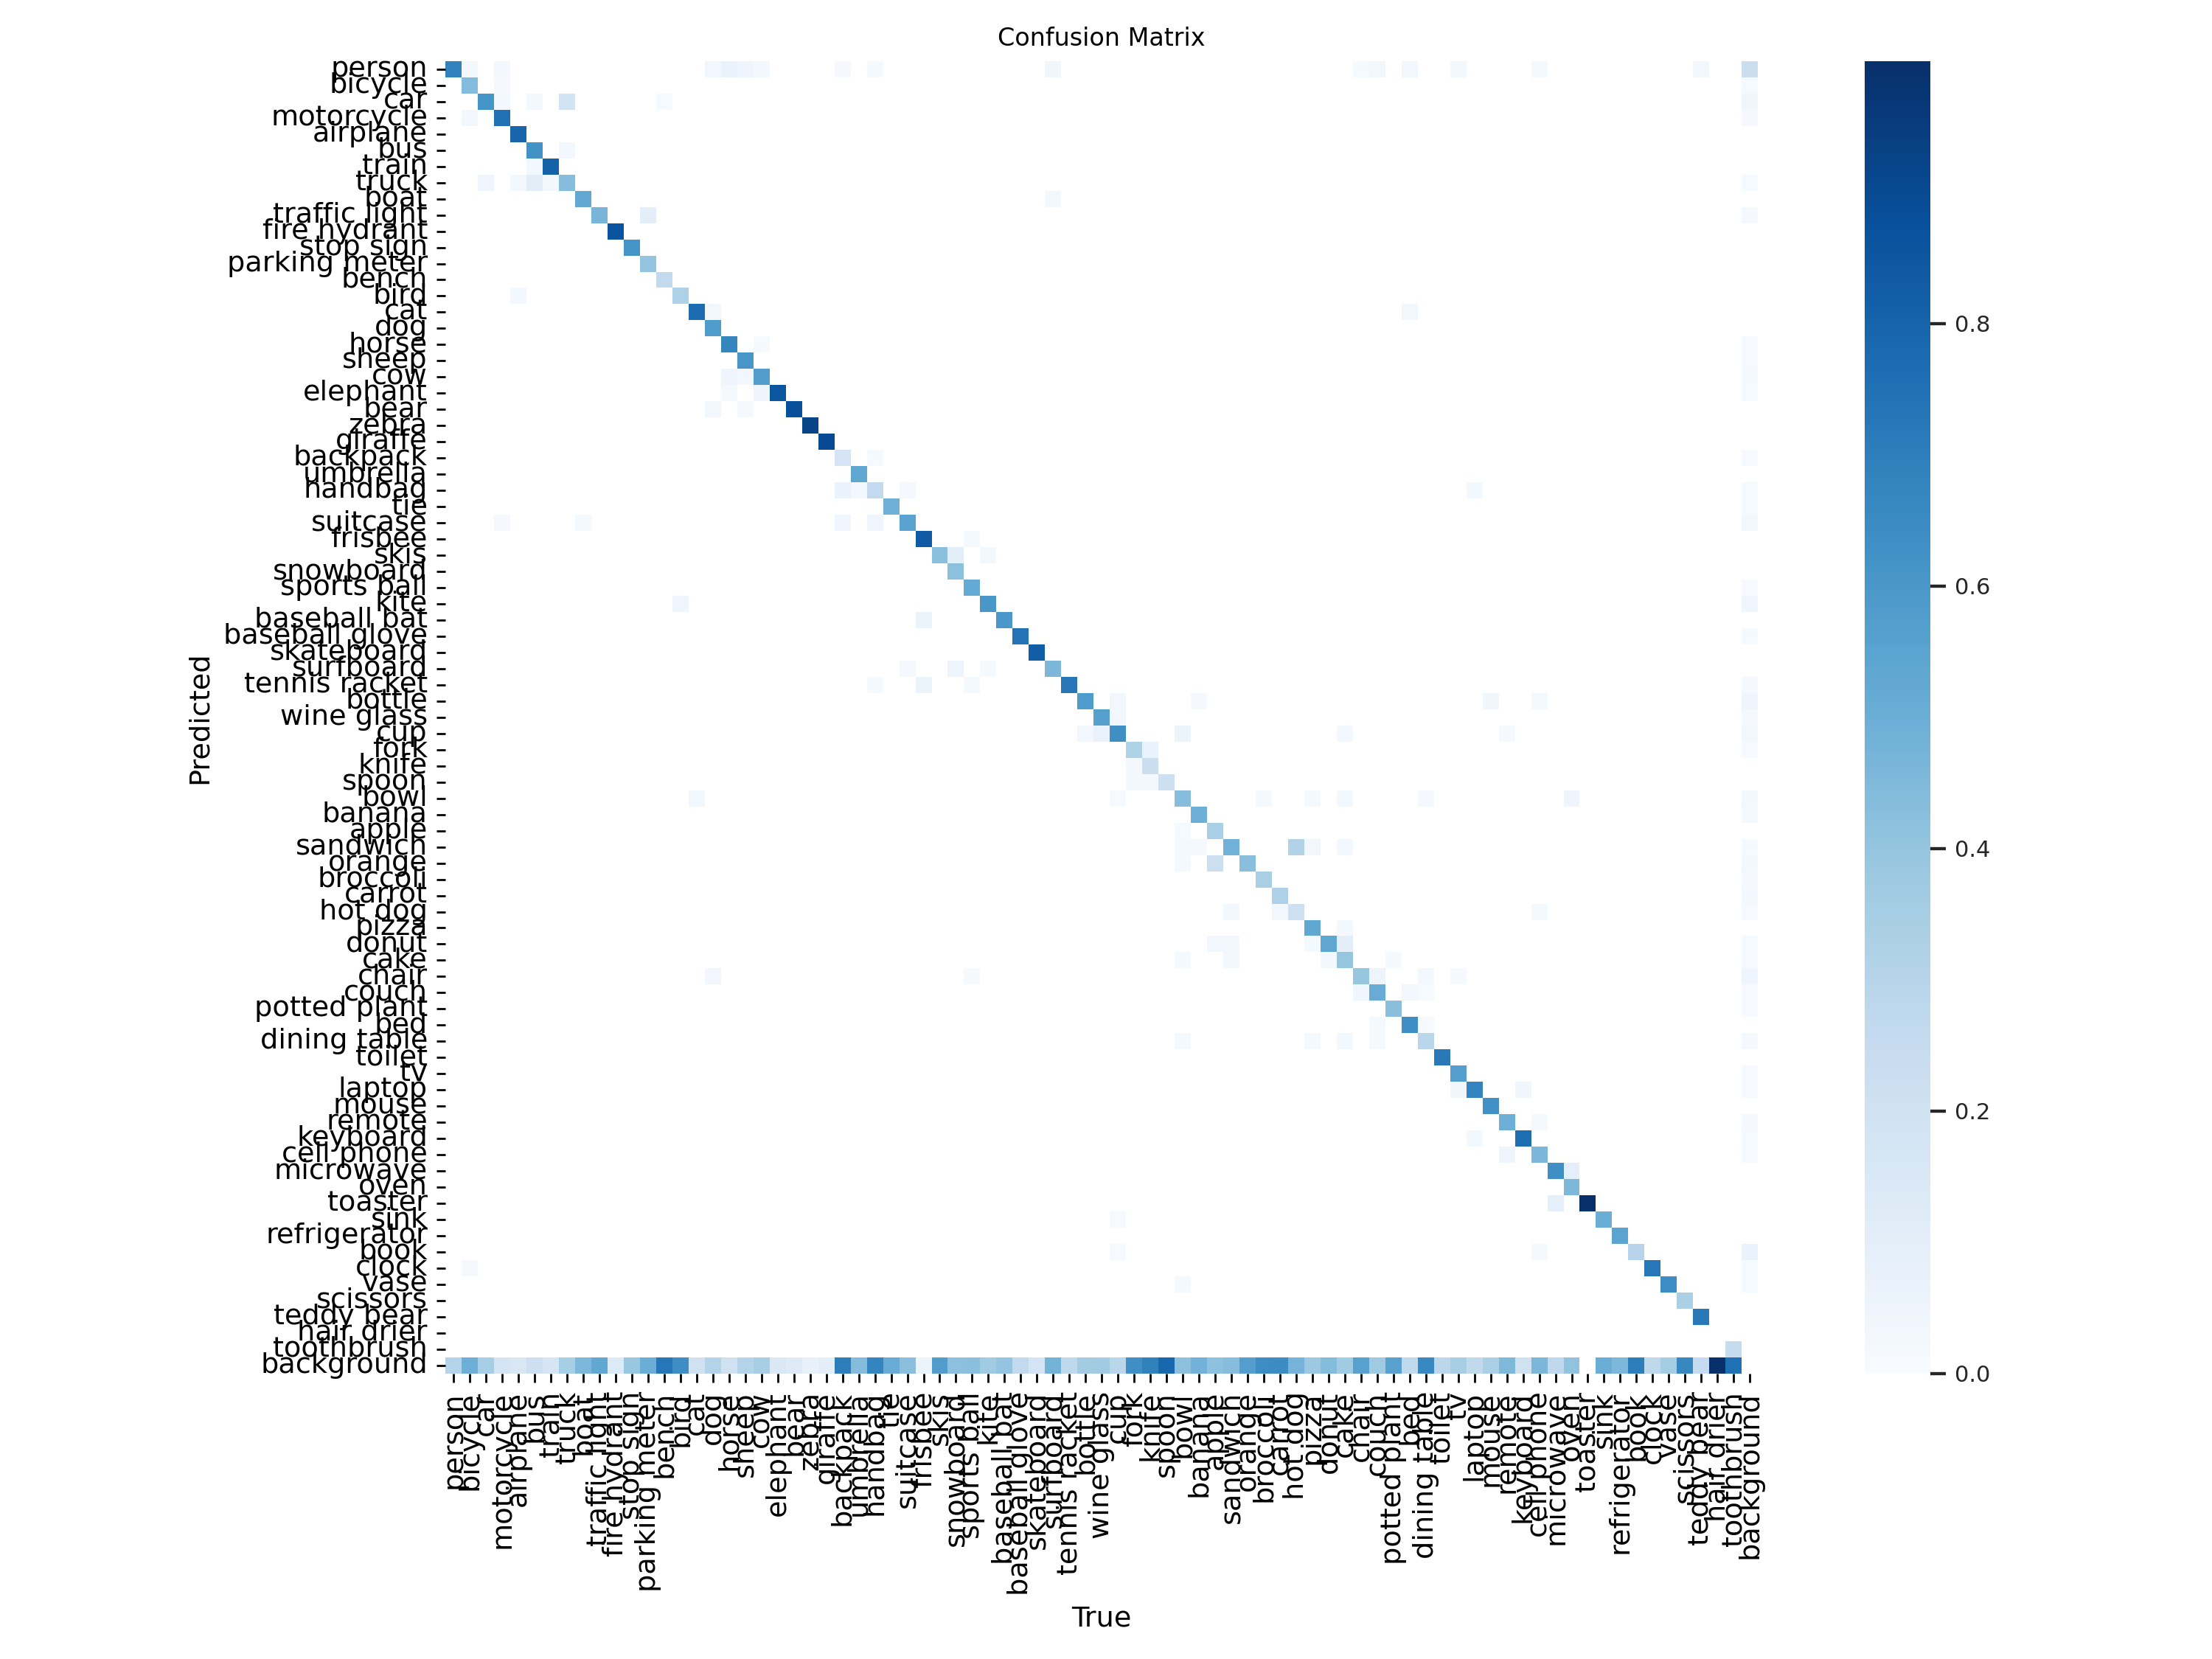

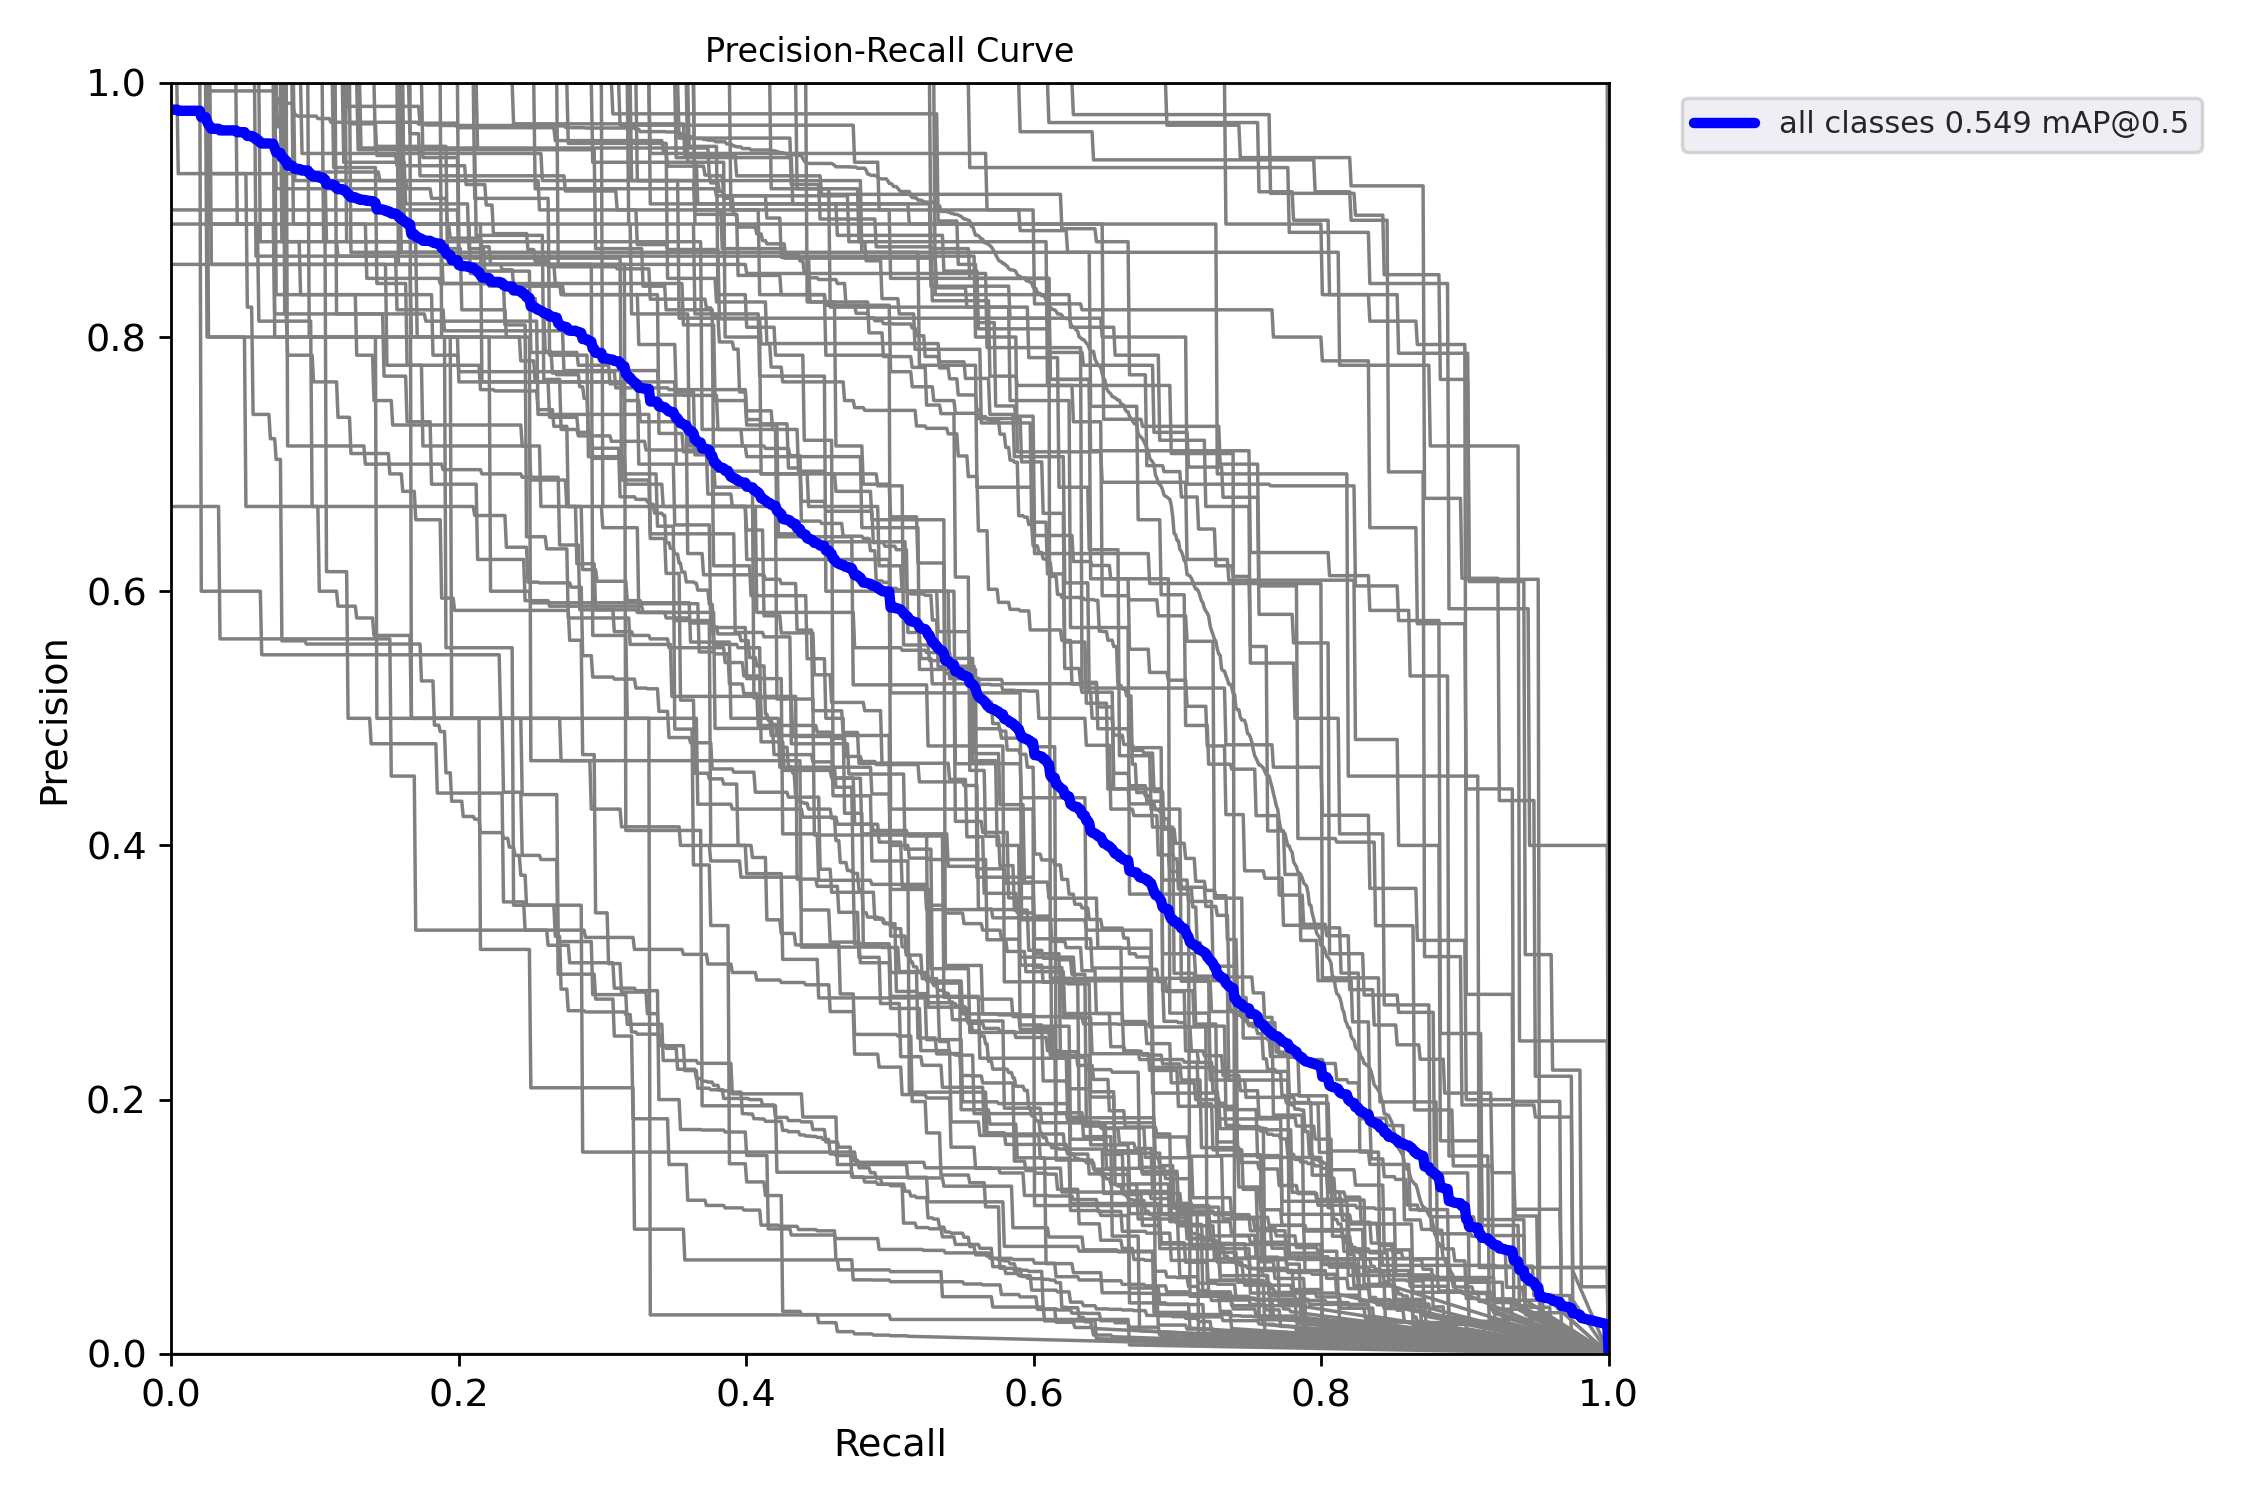

In [22]:
# Confusion matrix
import PIL
display(PIL.Image.open("runs/val/exp/confusion_matrix.png"))

# Precision-Recall curve
display(PIL.Image.open("runs/val/exp/PR_curve.png"))

# Exibir resultados resumidos
#with open("runs/train/exp1/results.csv") as f:
    #print(f.read())

### Predição em Imagens

In [12]:
!wget -O /content/test_image.jpg https://www.pmsg.rj.gov.br/wp-content/uploads/2024/10/Cidade-Ilustrada-18.10-F.-Guimaraes-11.jpg

--2025-09-13 18:34:17--  https://www.pmsg.rj.gov.br/wp-content/uploads/2024/10/Cidade-Ilustrada-18.10-F.-Guimaraes-11.jpg
Resolving www.pmsg.rj.gov.br (www.pmsg.rj.gov.br)... 177.154.93.8, 2801:80:39b0::8
Connecting to www.pmsg.rj.gov.br (www.pmsg.rj.gov.br)|177.154.93.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338638 (331K) [image/jpeg]
Saving to: ‘/content/test_image.jpg’

/content/test_image 100%[===================>] 330.70K   256KB/s    in 1.3s    

2025-09-13 18:34:20 (256 KB/s) - ‘/content/test_image.jpg’ saved [338638/338638]



In [14]:
!python detect.py --weights runs/train/exp1/weights/best.pt \
                  --img 640 \
                  --source /content/test_image.jpg


detect: weights=['runs/train/exp1/weights/best.pt'], source=/content/test_image.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-430-g459d8bf0 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/1 /content/test_image.jpg: 448x640 5 persons, 1 bicycle, 1 handbag, 1 clock, 31.2ms
Speed: 0.5ms pre-process, 31.2ms inference, 81.4ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


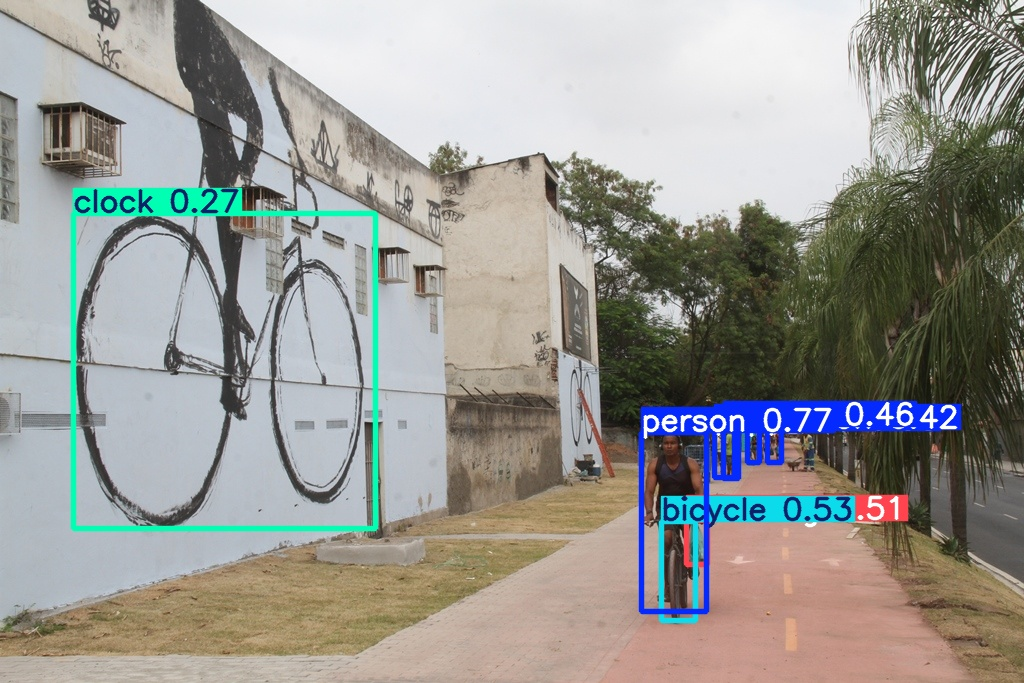

In [17]:
# Exibir resultado

# Caminho da imagem gerada pelo YOLO (padrão YOLOv5)
# adjust the path according to your output folder
img_path = "/content/yolov5/runs/detect/exp/test_image.jpg" # corrected path

# Exibir imagem no notebook
display(Image(filename=img_path))

In [23]:
!wget -O /content/test_image2.jpg https://didatica.tech/wp-content/uploads/2020/10/image-8.png

--2025-09-13 18:48:27--  https://didatica.tech/wp-content/uploads/2020/10/image-8.png
Resolving didatica.tech (didatica.tech)... 173.236.230.93
Connecting to didatica.tech (didatica.tech)|173.236.230.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2144314 (2.0M) [image/png]
Saving to: ‘/content/test_image2.jpg’

/content/test_image 100%[===================>]   2.04M  1.56MB/s    in 1.3s    

2025-09-13 18:48:29 (1.56 MB/s) - ‘/content/test_image2.jpg’ saved [2144314/2144314]



In [25]:
!python detect.py --weights runs/train/exp1/weights/best.pt \
                  --img 640 \
                  --source /content/test_image2.jpg

detect: weights=['runs/train/exp1/weights/best.pt'], source=/content/test_image2.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-430-g459d8bf0 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
image 1/1 /content/test_image2.jpg: 288x640 1 dog, 4 horses, 1 cow, 30.8ms
Speed: 0.5ms pre-process, 30.8ms inference, 116.7ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp2


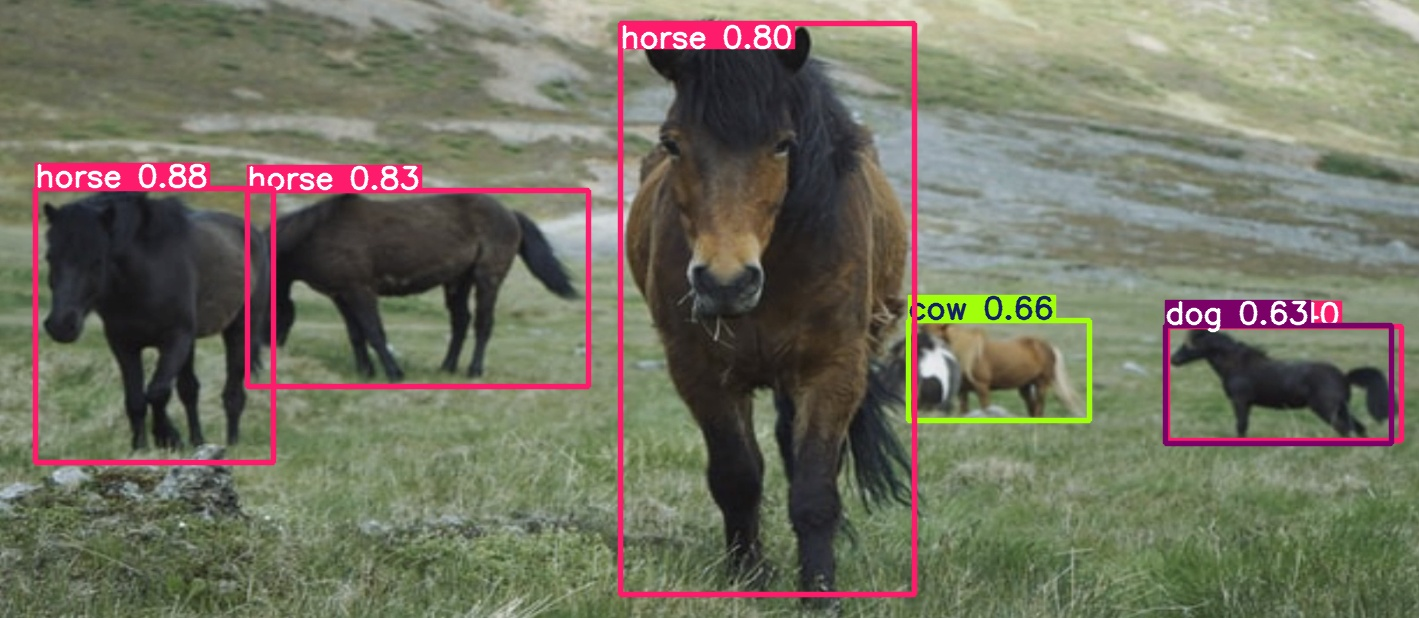

In [27]:
# Exibir resultado

# Caminho da imagem gerada pelo YOLO (padrão YOLOv5)
# adjust the path according to your output folder
img_path = "/content/yolov5/runs/detect/exp2/test_image2.jpg" # corrected path

# Exibir imagem no notebook
display(Image(filename=img_path))